Continuous Bump Attractor Model
===============================



## notebook settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

## Continuous Bump Attractor Model



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



#### Simulation



To run a simulation, first we need to define a network model.
The class Network takes three mandatory arguments:

1.  The name of the configuration file that defines the model,
    eg 'config<sub>bump.yml</sub>', these files are in ../conf/ and well detailed.

2.  The name of the output file that will contain the simulation data.
    eg 'bump'. Simulation results will be saved as a data frame to '../data/simul/bump.h5'.

3.  The path to the root of this repository.

One can also pass extra arguments to Network, basically any parameter that is in the config file so that it will be overwritten.

Here is an example:



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"
model = Network('config_bump.yml', 'bump', REPO_ROOT, VERBOSE=1, NUM_THREADS=116)
# Here for example, we are adding two extra parameters

Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
Saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
Jab [[-2.75]]
Tuning, KAPPA [0.4]
Asymmetry, SIGMA [0.]
Iext [14.]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  all to all connectivity
  with cosine structure
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 1000 Na [1000] K 1.0 Ka [1.]
  Iext [14.] Jab [-2.75]
  Tuning, KAPPA [0.4]
  Asymmetry, SIGMA [0.]
  MF Rates: [5.09090909]
  Transfert Func Sigmoid
  Running simulation
  times (s) 0.5 rates (Hz) [2.18]
  times (s) 1.0 rates (Hz) [2.17]
  STIM ON
  times (s) 1.5 rates (Hz) [6.25]
  STIM OFF
  times (s) 2.0 rates (Hz) [5.87]
  times (s) 2.5 rates (Hz) [5.85]
  times (s) 3.0 rates (Hz) [5.87]
  times (s) 3.5 rates (Hz) [5.88]
  times (s) 4.0 rates (Hz) [5.87]
  saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
  Elapsed (with compilation) = 7.382569322013296s
#+end_example

#### Analysis



Most of the code for the analysis of the results of the simulations comes from
../src/analysis/plot<sub>utils.py</sub> and ../src/analysis/decode.py But here we will
reimplement some of it.



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump, circcvl

##### Load data



In [1]:
df = pd.read_hdf(REPO_ROOT + "/data/simul/bump.h5", mode="r")  
print(df.head())

rates        ff       h_E  neurons   time
0  1.750975  6.669991 -6.010844        0  0.499
1  2.879797  1.936005 -6.011033        1  0.499
2  3.251747 -0.653561 -6.011222        2  0.499
3  0.755492 -1.949484 -6.011411        3  0.499
4  1.402129  3.749234 -6.011600        4  0.499

The dataframe from a simulation contains 5 cols corresponding to
the rates of the neurons, the total feedforward input (ff), the net recurrent input (h<sub>E</sub>), the neuron id, and the time step.



##### Rates



###### Raster plot



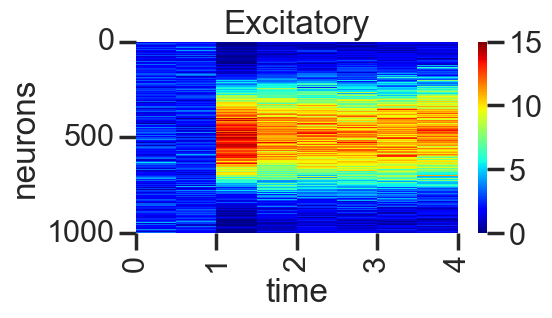

In [1]:
fig, ax = plt.subplots()
pt = pd.pivot_table(df, values="rates", index=["neurons"], columns="time")

sns.heatmap(pt, cmap="jet", ax=ax, vmax=15, vmin=0)
ax.set_yticks([0, 500, 1000], [0, 500, 1000])
ax.set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax.set_title('Excitatory')

plt.show()

###### Rates Distribution



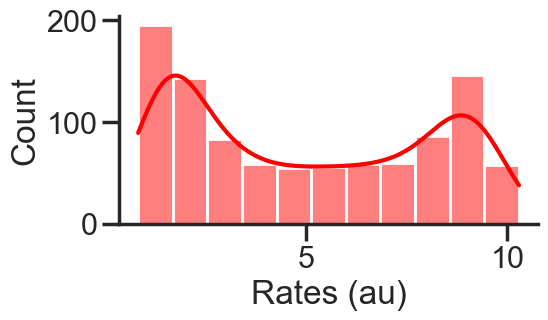

In [1]:
mean_df = df.groupby("neurons").mean()
mean_df[mean_df.rates<.01] = np.nan

sns.histplot(mean_df, x=mean_df.rates, kde=True, color='r')
plt.xlabel("Rates (au)")
plt.show()

##### Tuning



###### Fourier moments and phase



Here we use the functions from ../src/analysis/decode.py to decode the location and amplitude of the bump.



In [1]:
data = df.groupby(['time'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])

print(data.head())

time        m0        m1     phase
0  0.499  2.181534  0.032431  2.262011
1  0.999  2.167945  0.083064  2.123314
2  1.499  6.249701  7.102196  3.164585
3  1.999  5.867596  5.310970  3.190126
4  2.499  5.853998  5.470547  3.245525

This new dataframe contains 4 cols: the time step, the mean activity (m0), the amplitude of the bump (m1, this is the first fourier moment of the population vec)
and the location or phase of the center of the bump.

We can look at the time course of these observables



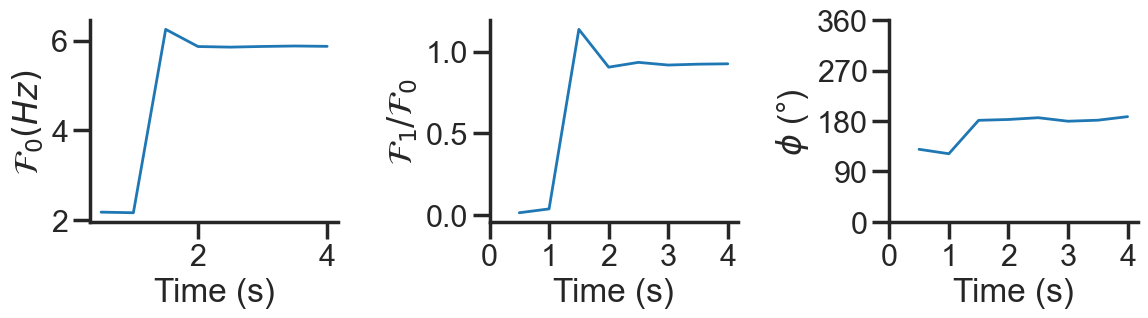

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y='m0', legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\mathcal{F}_0 (Hz)$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['m1']/data['m0'], legend=False, lw=2, ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[2])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\phi$ (°)')
ax[2].set_xticks([0, 1, 2, 3, 4])
ax[2].set_yticks([0, 90, 180, 270, 360])
plt.show()

###### Spatial profile



We can alternatively look at the shape of the bump at different epochs, using circcvl from ../src/analysis/decode.py
Here, during stimulation and during the delay period:



In [1]:
# Stimulus presentation
df_stim = df[df.time < 1.5]
df_stim = df_stim[df_stim.time >= 1]

mean_stim = df_stim.groupby("neurons").mean()
array = mean_stim[["rates"]].to_numpy()

X_stim = circcvl(array[:, 0], windowSize=10)
m0, m1, phase = decode_bump(X_stim)

X_stim = np.roll(X_stim, int((phase / 2.0 / np.pi - 0.5) * X_stim.shape[0]))

In [1]:
df_delay = df[df.time >= 1.5]

mean_delay = df_delay.groupby("neurons").mean()
array = mean_delay[["rates"]].to_numpy()

X_delay = circcvl(array[:, 0], windowSize=10)
m0, m1, phase = decode_bump(X_delay)

X_delay = np.roll(X_delay, int((phase / 2.0 / np.pi - 0.5) * X_delay.shape[0]))

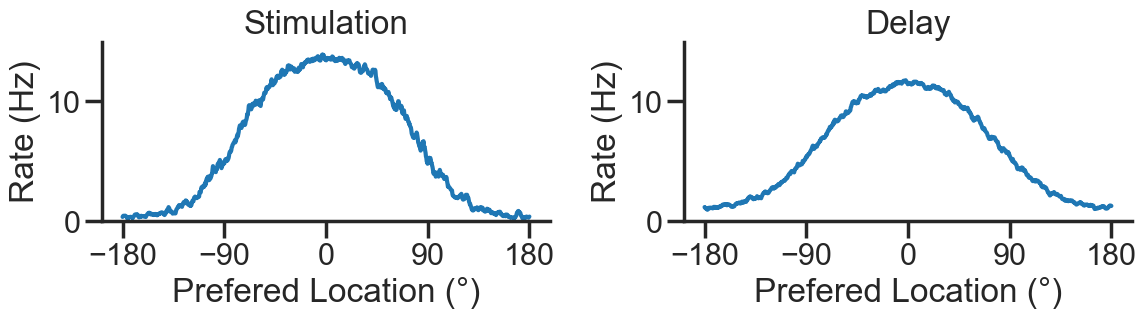

In [1]:
theta = np.linspace(-180, 180, X_stim.shape[0])
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(theta, X_stim)
ax[0].set_xlabel("Prefered Location (°)")
ax[0].set_ylabel("Rate (Hz)")
ax[0].set_xticks([-180, -90, 0, 90, 180])
ax[0].set_title('Stimulation')
ax[0].set_ylim([0, 15])

ax[1].plot(theta, X_delay)
ax[1].set_xlabel("Prefered Location (°)")
ax[1].set_ylabel("Rate (Hz)")  
ax[1].set_xticks([-180, -90, 0, 90, 180])
ax[1].set_title('Delay')
ax[1].set_ylim([0, 15])
plt.show()

### Multiple trials



#### Simulations



In [1]:
ini_list = np.arange(25, 50)

REPO_ROOT = "/home/leon/tmp/rnn_numba"

IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for ini in ini_list:
    print('##########################################')
    print("trial", ini)
    print('##########################################')

    model = Network('config_bump.yml', 'bump_ini_%d' % ini, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  ##########################################
  trial 25
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_25.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.199274960090406s
  ##########################################
  trial 26
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_26.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.282144900993444s
  ##########################################
  trial 27
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/da

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
ini_list = np.arange(0, 50)

df_list = []

for ini in ini_list:
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_ini_%d.h5" % ini, mode="r")
    df_i['trial'] = ini
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates        ff       h_E  neurons   time  trial
0  3.048436 -3.519403 -5.976190        0  0.499      0
1  2.469401 -0.738135 -5.975781        1  0.499      0
2  1.352286  3.643990 -5.975371        2  0.499      0
3  1.230724 -6.516477 -5.974960        3  0.499      0
4  1.657853  0.255504 -5.974548        4  0.499      0

In [1]:
data = df.groupby(['time', 'trial'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])
print(data.head())

time  trial        m0        m1     phase
0  0.499      0  2.152970  0.053400  4.523900
1  0.499      1  2.181172  0.077984  3.345704
2  0.499      2  2.188593  0.065588  1.236631
3  0.499      3  2.171368  0.053285  0.990382
4  0.499      4  2.170371  0.002783  4.552415

In [1]:
end_point = data[data.time == data.time.iloc[-1]]
print(end_point.head())

time  trial        m0        m1     phase
350  3.999      0  5.906027  5.449286  2.892502
351  3.999      1  5.891126  5.420843  3.135631
352  3.999      2  5.874590  5.361630  3.339823
353  3.999      3  5.891533  5.479044  2.938857
354  3.999      4  5.886632  5.519670  3.141416

##### Phases



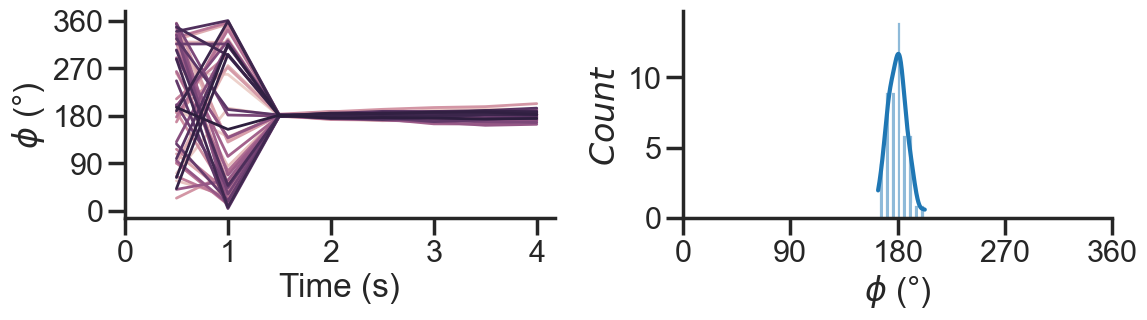

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[0], hue='trial')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\phi$ (°)')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_yticks([0, 90, 180, 270, 360])

sns.histplot(data=end_point, x=end_point['phase']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi$ (°)')
ax[1].set_ylabel('$Count$')
ax[1].set_xticks([0, 90, 180, 270, 360])
plt.show()

##### Accuracy / Precision Errors



In [1]:
from scipy.stats import circmean
stim_phase = np.pi

end_point['accuracy'] = end_point.phase - stim_phase
end_point['precision'] = end_point.phase - circmean(end_point.phase)
print(end_point.head())

#+begin_example
        time  trial        m0        m1     phase  accuracy  precision
  350  3.999      0  5.906027  5.449286  2.892502 -0.249091  -0.243759
  351  3.999      1  5.891126  5.420843  3.135631 -0.005961  -0.000629
  352  3.999      2  5.874590  5.361630  3.339823  0.198231   0.203562
  353  3.999      3  5.891533  5.479044  2.938857 -0.202736  -0.197404
  354  3.999      4  5.886632  5.519670  3.141416 -0.000176   0.005156
  /tmp/ipykernel_3718977/1857574883.py:4: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,col_indexer] = value instead

  See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    end_point['accuracy'] = end_point.phase - stim_phase
  /tmp/ipykernel_3718977/1857574883.py:5: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,

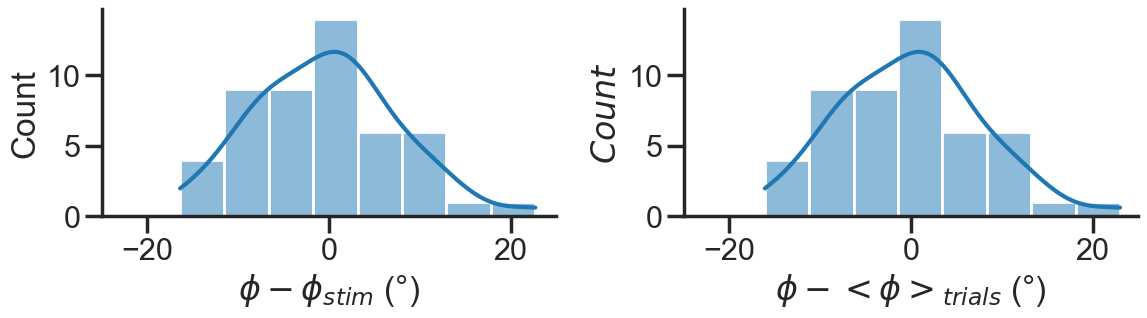

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.histplot(data=end_point, x=end_point['accuracy']*180/np.pi, legend=False, lw=2, ax=ax[0], kde=True)
ax[0].set_xlabel('$\phi - \phi_{stim}$ (°)')
ax[0].set_ylabel('Count')
ax[0].set_xlim([-25, 25])

sns.histplot(data=end_point, x=end_point['precision']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi - <\phi>_{trials}$ (°)')
ax[1].set_ylabel('$Count$')
ax[1].set_xlim([-25, 25])

plt.show()

### Parameter Space



#### Changing J0



##### Simulation



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"  
J0_list = np.linspace(2, 4, 11)
print(J0_list)

[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4. ]

In [1]:
IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for J0 in J0_list:
    model = Network('config_bump.yml', 'bump_J0_%.1f' % J0, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT,
                    Jab=[-J0], VERBOSE=0)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J0_2.0.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.148258017026819s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J0_2.2.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.156889496953227s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J0_2.4.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.209725192980841s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J0_2.6.h5
  Loa

##### Analysis



In [1]:
J0_list = np.linspace(2, 4, 11)

df_list = []

for i in range(J0_list.shape[0]):
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_J0_%.1f.h5" % J0_list[i], mode="r")
    df_i['J0'] = J0_list[i]
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates        ff       h_E  neurons   time   J0
0  2.979453  9.873323 -5.351787        0  0.499  2.0
1  2.830152 -4.640124 -5.351531        1  0.499  2.0
2  3.098595  2.158386 -5.351274        2  0.499  2.0
3  3.415840 -6.115636 -5.351014        3  0.499  2.0
4  3.625322  0.626738 -5.350751        4  0.499  2.0

In [1]:
res = df.groupby(['time', 'J0'])['rates'].apply(decode_bump).reset_index()
res[['m0', 'm1', 'phase']] = pd.DataFrame(res['rates'].tolist(), index=res.index)
res = res.drop(columns=['rates'])
print(res.head())

time   J0        m0        m1     phase
0  0.499  2.0  2.643238  0.074680  4.044520
1  0.499  2.2  2.506782  0.028911  3.321685
2  0.499  2.4  2.372550  0.021852  6.135836
3  0.499  2.6  2.273263  0.004630  5.104311
4  0.499  2.8  2.154610  0.054661  5.969938

In [1]:
last = res[res.time==res.time.iloc[-1]]
last = last.drop(columns=['time'])
print(last.head())

J0        m0        m1     phase
77  2.0  7.223276  0.059838  5.009779
78  2.2  6.785306  0.235569  5.189480
79  2.4  6.319345  2.347832  3.364468
80  2.6  6.067178  4.456472  2.924240
81  2.8  5.822750  5.580686  3.089648

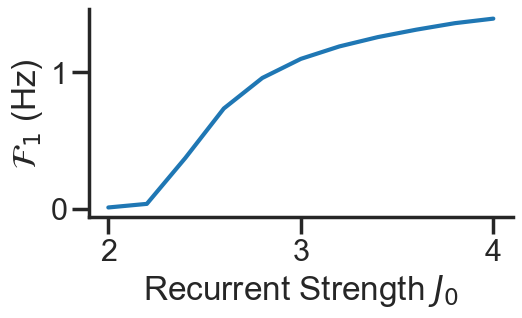

In [1]:
sns.lineplot(last, x='J0', y=last['m1']/last['m0'])
plt.xlabel('Recurrent Strength $J_0$')
plt.ylabel('$\mathcal{F}_1$ (Hz)')
plt.show()

#### Changing J1



##### Simulation



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"  
J1_list = np.linspace(0, 1, 11)
print(J1_list)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

In [1]:
IF_LOAD_MAT = 0
IF_SAVE_MAT = 0

for J1 in J1_list:
    model = Network('config_bump.yml', 'bump_J1_%.1f' % J1, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT,
                    KAPPA=[J1], VERBOSE=0)

    model.run()

    IF_LOAD_MAT = 0
    IF_SAVE_MAT = 0

#+begin_example
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J1_0.0.h5
  Generating matrix Cij
  Running simulation
  Elapsed (with compilation) = 7.366484464961104s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J1_0.1.h5
  Generating matrix Cij
  Running simulation
  Elapsed (with compilation) = 7.422051499015652s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J1_0.2.h5
  Generating matrix Cij
  Running simulation
  Elapsed (with compilation) = 7.4423628660151735s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_J1_0.3.h5
  Generating matrix Cij
  Running simulation
  Elapsed (with compilation) = 7.4173392209922895s
  Loading config from /home/leon/tmp/rnn_numba/conf/config

##### Analysis



In [1]:
J1_list = np.linspace(0, 1, 11)

df_list = []

for i in range(J1_list.shape[0]):
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_J1_%.1f.h5" % J1_list[i], mode="r")
    df_i['J1'] = J1_list[i]
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates         ff       h_E  neurons   time   J1
0  2.596293  10.528442 -5.977084        0  0.499  0.0
1  1.005097   4.559610 -5.977084        1  0.499  0.0
2  3.421589  -1.393433 -5.977084        2  0.499  0.0
3  2.504058  -1.709201 -5.977084        3  0.499  0.0
4  2.531308  -2.055951 -5.977084        4  0.499  0.0

In [1]:
res = df.groupby(['time', 'J1'])['rates'].apply(decode_bump).reset_index()
res[['m0', 'm1', 'phase']] = pd.DataFrame(res['rates'].tolist(), index=res.index)
res = res.drop(columns=['rates'])
print(res.head())

time   J1        m0        m1     phase
0  0.499  0.0  2.176421  0.030178  0.875617
1  0.499  0.1  2.179004  0.034184  3.006940
2  0.499  0.2  2.198129  0.047730  2.877824
3  0.499  0.3  2.168901  0.060924  5.164094
4  0.499  0.4  2.186594  0.116088  1.851756

In [1]:
last = res[res.time==res.time.iloc[-1]]
last = last.drop(columns=['time'])
print(last.head())

J1        m0        m1     phase
77  0.0  5.765645  0.012321  0.674993
78  0.1  5.749736  0.028280  2.303137
79  0.2  5.710444  0.017764  1.827065
80  0.3  5.739739  0.139635  0.915704
81  0.4  5.875741  5.332170  2.996620

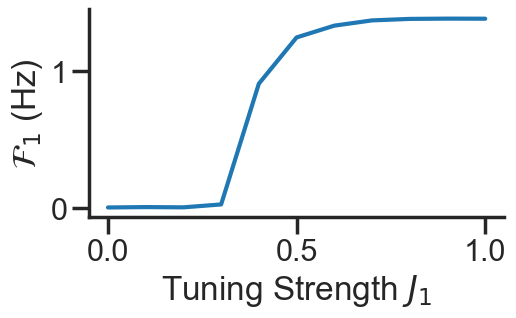

In [1]:
sns.lineplot(last, x='J1', y=last['m1']/last['m0'])
plt.xlabel('Tuning Strength $J_1$')
plt.ylabel('$\mathcal{F}_1$ (Hz)')
plt.show()

#### Changing I0



##### Simulation



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"  
I0_list = np.linspace(10, 30, 11)
print(I0_list)

[10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]

In [1]:
IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for I0 in I0_list:
    model = Network('config_bump.yml', 'bump_I0_%.1f' % I0, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT,
                    Iext=[I0], VERBOSE=0)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_I0_10.0.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.1810109979705885s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_I0_12.0.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.145081017049961s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_I0_14.0.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.189407243044116s
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_I0_16.0.h5


##### Analysis



In [1]:
I0_list = np.linspace(10, 30, 11)

df_list = []

for i in range(I0_list.shape[0]):
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_I0_%.1f.h5" % I0_list[i], mode="r")
    df_i['I0'] = I0_list[i]
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates        ff       h_E  neurons   time    I0
0  2.991737  2.570595 -6.026989        0  0.499  10.0
1  1.881618  0.980764 -6.026621        1  0.499  10.0
2  2.940181 -5.795781 -6.026254        2  0.499  10.0
3  1.170019 -0.076887 -6.025889        3  0.499  10.0
4  2.863903  2.739512 -6.025525        4  0.499  10.0

In [1]:
res = df.groupby(['time', 'I0'])['rates'].apply(decode_bump).reset_index()
res[['m0', 'm1', 'phase']] = pd.DataFrame(res['rates'].tolist(), index=res.index)
res = res.drop(columns=['rates'])
print(res.head())

time    I0        m0        m1     phase
0  0.499  10.0  2.201509  0.059715  4.983395
1  0.499  12.0  2.158195  0.189081  1.364071
2  0.499  14.0  2.171295  0.075219  3.018876
3  0.499  16.0  2.177301  0.077118  1.571473
4  0.499  18.0  2.169490  0.118072  4.750044

In [1]:
last = res[res.time==res.time.iloc[-1]]
last = last.drop(columns=['time'])
print(last.head())

I0        m0        m1     phase
77  10.0  4.748553  3.372240  2.832190
78  12.0  5.299185  4.570933  2.924747
79  14.0  5.893788  5.414350  2.964203
80  16.0  6.393171  5.944921  3.220780
81  18.0  6.918446  6.382643  3.213330

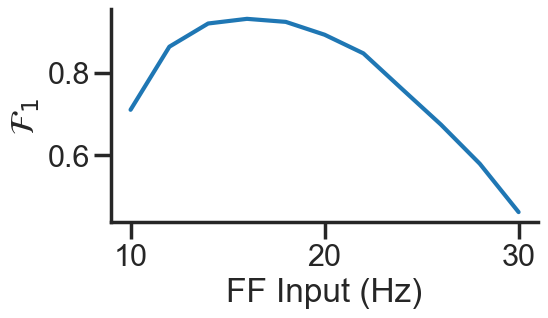

In [1]:
sns.lineplot(last, x='I0', y=last['m1']/last['m0'])
plt.ylabel('$\mathcal{F}_1$')
plt.xlabel('FF Input (Hz)')
plt.show()